In [423]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
from keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import json, codecs
import pickle
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import r2_score
%matplotlib notebook

Предсказывать матрицу L на L контактов в белке
Там где расстояние больше 8 А будет 0, меньше - 1
В теории будет составлены матрицы бля белков с более точной дискретизацие контактов, поделённоые на большее кол-во классов
****
Попробовать редуцировать L до констатного значения, для того, чтобы сделать L одинаковым для всех белков.
Выбрать небольшой промежуток 
Предсказывать 5 элементов для каждой аминокислоты(надо попробовать)

Stochastic gradient descent is an optimization algorithm that estimates the error gradient for the current state of the model using examples from the training dataset, then updates the weights of the model using the back-propagation of errors algorithm, referred to as simply backpropagation.

## Data-preparation

### Файл с преобразованной выборкой, состоящей из 8747 белков, каждый длиной L и 56 признаков
Файл, сформированный заранее, состоящий из признаков для обучения. В качестве признаков используются аторичная структура(3), PSSM(20), FASTA-кодировка(20), растворимость(1), 8 различных типов АК по радикалу(8), 4 различных типа АК по полярности(4)

In [424]:
pkl_file = open('data.pkl', 'rb')
data1 = pickle.load(pkl_file)
pkl_file.close()

### Файл с матрицами попарных расстояний для каждого белка из списка хороших белков
Для всех белков из списка "хороших" белков были посчитаны опрные матрицы размерность 5 x L, которые и будут предсказываться

In [425]:
import json
with open("D:\Загрузки\supporting_matrix\data.json", "r") as read_file:
    data = json.load(read_file)

In [426]:
coords1 = pd.DataFrame()
for i in range(len(data['data'])):
    coords = pd.DataFrame({'pdb': [data['data'][i][0]], 'matrix_coord':[data['data'][i][1]]})
    coords1 =  pd.concat([coords1, coords], ignore_index=True)

In [427]:
god_prot = pd.read_csv('good_prot.csv')

### Подчищение выборки
Была незначительная ошибка при формировании выборки, связанная с тем, что некоторые белки повторялись, в связи с чем эти повторения необходимо удалить

In [428]:
s=0
listtodrop = []
coo = pd.DataFrame()
for pdb in god_prot.pdb_name:
    if pdb in coords1.pdb.tolist():
        coo = pd.concat([coo, coords1.loc[coords1['pdb'] == pdb]], ignore_index=True)
    else:
        listtodrop.append(pdb)

In [429]:
#coo.head(5)

In [430]:
target_basic = coo.matrix_coord.values

In [431]:
listtodrop

['5ZBT',
 '5ZDS',
 '5ZEW',
 '6CKD',
 '6E0K',
 '6FZK',
 '6G5R',
 '6HZ2',
 '6I3R',
 '6I5A',
 '6ITH',
 '6IW3',
 '6MNT',
 '6MPO',
 '6NZS',
 '6QAX',
 '6QB0',
 '6QB1']

In [432]:
target = coo.matrix_coord.values

In [433]:
data_features = pd.read_csv('pdb_and_features.csv')

In [434]:
indextodrop = []
for pdb in listtodrop:
    indextodrop.append(data_features.index[data_features.pdb_name == pdb].tolist())
    data_features = data_features[data_features.pdb_name != pdb]

In [435]:
for i in range(len(indextodrop)):
    del data1[indextodrop[i][0]]

In [436]:
data_features = data_features.reset_index(drop=True)

Проверяем, всё ли теперь верно и совпадают ли размерности списков матриц для обучения и список опорных матриц  

In [437]:
len(target)

8747

In [438]:
len(data1)

8747

### Несовпадение размеров белков по базам pdb и mmtf
В процессе проверки данных обнаружилось, что длины белков по обучающей выборке и по опорной матрице отличаются, чего быть не должно, так как это один и тот же белок.

In [439]:
for i in range(100):
    if np.shape(data1[i])[0] != np.shape(target[i])[0]:
        print(i,'Длина белка по базе pdb', np.shape(data1[i])[0], 'Длина белка по базе mmtf', np.shape(target[i])[0])

6 Длина белка по базе pdb 164 Длина белка по базе mmtf 162
8 Длина белка по базе pdb 131 Длина белка по базе mmtf 130
12 Длина белка по базе pdb 314 Длина белка по базе mmtf 313
13 Длина белка по базе pdb 91 Длина белка по базе mmtf 83
14 Длина белка по базе pdb 108 Длина белка по базе mmtf 106
15 Длина белка по базе pdb 91 Длина белка по базе mmtf 83
18 Длина белка по базе pdb 189 Длина белка по базе mmtf 188
19 Длина белка по базе pdb 88 Длина белка по базе mmtf 85
20 Длина белка по базе pdb 177 Длина белка по базе mmtf 174
23 Длина белка по базе pdb 160 Длина белка по базе mmtf 158
24 Длина белка по базе pdb 87 Длина белка по базе mmtf 72
31 Длина белка по базе pdb 330 Длина белка по базе mmtf 284
32 Длина белка по базе pdb 130 Длина белка по базе mmtf 125
35 Длина белка по базе pdb 95 Длина белка по базе mmtf 87
40 Длина белка по базе pdb 321 Длина белка по базе mmtf 297
54 Длина белка по базе pdb 62 Длина белка по базе mmtf 56
55 Длина белка по базе pdb 134 Длина белка по базе mmt

Можно убедиться, что это один и тот же белок

In [440]:
def check_prot_size(i):
    print(data_features.iloc[i])
    print('---')
    print(coo.iloc[i])
    print('---')
    print('Длина белка из матрицы расстояний',np.shape(coo.iloc[i].matrix_coord)[0])
    print('Длина белка из выборки для обучения',np.shape(data1[i])[0])

In [441]:
check_prot_size(78)

Unnamed: 0                                                   78
pdb_name                                                   1AGY
FASTA         LGRTTRDDLINGNSASCRDVIFIYARGSTETGNLGTLGPSIASNLE...
Radical       0052253300404202753001010502232040020062002403...
Polarity      0011112200101101012000010101121010010001001102...
SS            CCCCCCEHHHHCCHHHCCCEEEEEECCCCCCCCCCCCHHHHHHHHH...
ACC           eeeee-e--ee-eeeee-e---------e-ee---e---e--ee--...
PSSM          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: 78, dtype: object
---
pdb                                                          1AGY
matrix_coord    [[-23.5914821625, -5.5430598259, 5.0590815544,...
Name: 78, dtype: object
---
Длина белка из матрицы расстояний 197
Длина белка из выборки для обучения 200


In [442]:
target_lin = []
for i in range(len(data_features)):
    target_lin.append(len(data_features.FASTA[i]))

In [443]:
target_lin = np.array(target_lin)

### Распределение длин белков в выборке
Можно посмотреть на распределение длин белков в сформированной выборке

Стоит отметить, что график сходится с графиком, предоставленном в работе DeepSF: deep convolutional neural network for
mapping protein sequences to folds не считая второго пика, который мог образоваться в связи с тем, что в выборке из статьи меньше или больше белков

[Supplementary-data](https://academic.oup.com/bioinformatics/article/34/8/1295/4708302#supplementary-data)
Figure S2 (b)

In [444]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), constrained_layout=True)
anchored_text = AnchoredText("mean = %.4f\n"
                                 "std  = %.4f\n"
                                 "max  = %.4f\n"
                                 "min  = %.4f\n"
                                 "median  = %.4f"
                                 % (target_lin.mean(), target_lin.std(), target_lin.max(), 
                                    target_lin.min(), np.median(target_lin)), loc='upper right')
ax.add_artist(anchored_text)
ax = sns.distplot(target_lin)

<IPython.core.display.Javascript object>

Границы "окна" для длин белков, которые будут предсказываться и на которых бужет обучаться модель

In [445]:
low_border = 15
high_border = 30

In [446]:
target_lin_ = target_lin[(target_lin<=high_border) & (target_lin>=low_border)]

Кол-во белков, которое у нас обудет в выборке после фильтровке по длине

In [447]:
len(target_lin_)

392

### Дозаполнение матриц
В данный момент было принято решение дозаполнить медианными по признакам недостающие строки в обучающей матрице и опорные матрицы медианными значениям по каждому из столбцов

In [448]:
data_f = []
mm = high_border#max(target_lin)
for i in range(len(data1)):
    if (high_border>=np.shape(data1[i])[0]):
        f = np.median(data1[0], axis = 0) + np.zeros((mm-np.shape(data1[i])[0], 1))
        #f = np.zeros((mm-np.shape(data1[i])[0], 56))
        data_f.append(np.concatenate((data1[i], f), axis=0))
    else:
         data_f.append(data1[i][:mm])

In [449]:
target.shape

(8747,)

In [450]:
target1 = []
mm1 = high_border
for i in range(len(target)):
    if (high_border>=np.shape(target[i])[0]):
        #ff = np.zeros((mm1-np.shape(target[i])[0], 5))
        ff = np.median(target[0], axis = 0) + np.zeros((mm1-np.shape(target[i])[0], 1))
        target1.append(np.concatenate((target[i], ff), axis=0))
    else:
        target1.append(target[i][:mm1])

In [451]:
data_f = np.array(data_f)

In [452]:
data_f.shape

(8747, 30, 56)

In [453]:
train = data_f[(target_lin<=high_border) & (target_lin>=low_border)]

In [454]:
target1 = np.array(target1)

In [455]:
np.shape(target1)

(8747, 30, 5)

In [456]:
target_f = target1[(target_lin<=high_border) & (target_lin>=low_border)]

In [457]:
train.shape

(392, 30, 56)

Добавляем ещё одну размерность к матрице признаков, т.к. CNN принимает данные в 4-х мерном формате

In [458]:
train = train.reshape(-1, mm, 56, 1)

In [459]:
#train = train[::, ::, np.r_[0:24, -20:0], ::]

Убираем первые 20 признаков, которые являются представлением АК в FASTA-формате

In [460]:
train = train[::, ::, :44, ::]

In [461]:
train.shape

(392, 30, 44, 1)

In [462]:
target_f.shape

(392, 30, 5)

In [463]:
target_f = target_f.reshape(target_f.shape[0], 5*(mm1))

Преобразовываем опроную матриц в вектор, т.к. CNN принимает в качестве выходных параметров вектор

In [464]:
target_f.shape

(392, 150)

In [465]:
#target = preprocessing.scale(target)

## CNN для предсказание опорной матрицы

In [466]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l2 # L2-regularisation
from sklearn.metrics import r2_score
from keras.callbacks import EarlyStopping
# ...
l2_lambda = 0.0001

Разбиваем наши дата-сеты на обучающую выборку, валидационную и тестовую

In [486]:
train_X,train_val_test,train_label,target_val_test = train_test_split(train, target_f, test_size=0.3, random_state=13)

In [487]:
test_X,valid_X,test_label,valid_label = train_test_split(train_val_test, target_val_test, test_size=0.5, random_state=13)

In [488]:
batch_size = 16
epochs = 50

In [489]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

### Созание модели для обучения

In [490]:
model = Sequential()
#1 слой
model.add(Conv2D(20, kernel_size=(mm, 5),activation='linear',padding='same', W_regularizer=l2(l2_lambda), input_shape=(mm, 44, 1)))
model.add(LeakyReLU(alpha=0.1))
#model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
#                                beta_initializer='zeros', gamma_initializer='ones', 
#                                moving_mean_initializer='zeros', moving_variance_initializer='ones', 
#                                beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))# уменьшаем размерность до 2 на 2
model.add(Dropout(0.3))
#2 слой
model.add(Conv2D(20, (mm, 5), activation='linear', W_regularizer=l2(l2_lambda), padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.3))
#3 слой3
model.add(Conv2D(20, (mm, 5), activation='linear', W_regularizer=l2(l2_lambda), padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.3))
#4 слой
#model.add(Conv2D(20, (mm, 10), activation='linear', W_regularizer=l2(l2_lambda), padding='same'))
#model.add(LeakyReLU(alpha=0.1))                  
#model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
#model.add(Dropout(0.1))
#5 слой
#model.add(Conv2D(20, (mm, 10), activation='linear', W_regularizer=l2(l2_lambda), padding='same'))
#model.add(LeakyReLU(alpha=0.1))                  
#model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
#model.add(Dropout(0.1))               
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(155, activation='linear', W_regularizer=l2(l2_lambda)))
model.add(LeakyReLU(alpha=0.1))           
model.add(Dropout(0.1))
model.add(Dense((5*(mm1)), activation='linear'))

D:\Programms\Anaconda\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(20, kernel_size=(30, 5), activation="linear", padding="same", input_shape=(30, 44, 1..., kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Programms\Anaconda\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(20, (30, 5), activation="linear", padding="same", kernel_regularizer=<keras.reg...)`
  if sys.path[0] == '':
D:\Programms\Anaconda\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(20, (30, 5), activation="linear", padding="same", kernel_regularizer=<keras.reg...)`
D:\Programms\Anaconda\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(155, activation="linear", kernel_regularizer=<keras.reg...)`


In [491]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 30, 44, 20)        3020      
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 30, 44, 20)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 15, 22, 20)        0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 15, 22, 20)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 15, 22, 20)        60020     
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 15, 22, 20)        0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 8, 11, 20)         0         
__________

1) Батч-нормализация (не) нужна
2) Чем меньше данныых тем меньше слоёв лучше использовать
3) При уменьшении слоёв происходит переобучение, мб уменьшить лёрнинг рейт
4) трёх слоёв достаточно
5) батч-сайз = 16

In [492]:
#optimizer=keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

Компилируем модель. В качетсве оптимизатора используем обычный ADAM, ф-ция поетрь -- среднеквадратичная средняя ошибка, метрики -- средняя абсолютная ошибка и коэфициент детерминации R^2

In [493]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(lr=0.001), metrics=['msle', 'mae', coeff_determination])

Обучаем модель

In [494]:
train_dropout = model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,
                          validation_data=(valid_X, valid_label))

Train on 274 samples, validate on 59 samples
Epoch 1/50
274/274 [==============================] - 3s 12ms/step - loss: 71.8289 - mean_squared_logarithmic_error: 0.7037 - mean_absolute_error: 5.8700 - coeff_determination: -0.1038 - val_loss: 59.2885 - val_mean_squared_logarithmic_error: 0.6751 - val_mean_absolute_error: 5.4132 - val_coeff_determination: 0.0175
Epoch 2/50
274/274 [==============================] - 2s 7ms/step - loss: 61.9281 - mean_squared_logarithmic_error: 0.6142 - mean_absolute_error: 5.4754 - coeff_determination: 0.0495 - val_loss: 46.0829 - val_mean_squared_logarithmic_error: 0.6932 - val_mean_absolute_error: 4.8596 - val_coeff_determination: 0.2342
Epoch 3/50
274/274 [==============================] - 2s 7ms/step - loss: 50.1472 - mean_squared_logarithmic_error: 0.5725 - mean_absolute_error: 4.9577 - coeff_determination: 0.2302 - val_loss: 37.7299 - val_mean_squared_logarithmic_error: 0.7090 - val_mean_absolute_error: 4.4339 - val_coeff_determination: 0.3703
Epoch

Epoch 27/50
274/274 [==============================] - 2s 7ms/step - loss: 15.1768 - mean_squared_logarithmic_error: 0.4270 - mean_absolute_error: 2.7333 - coeff_determination: 0.7647 - val_loss: 28.8833 - val_mean_squared_logarithmic_error: 0.6273 - val_mean_absolute_error: 3.6348 - val_coeff_determination: 0.5249
Epoch 28/50
274/274 [==============================] - 2s 8ms/step - loss: 15.4424 - mean_squared_logarithmic_error: 0.4296 - mean_absolute_error: 2.7554 - coeff_determination: 0.7582 - val_loss: 29.4663 - val_mean_squared_logarithmic_error: 0.6363 - val_mean_absolute_error: 3.6956 - val_coeff_determination: 0.5148
Epoch 29/50
274/274 [==============================] - 2s 7ms/step - loss: 15.0975 - mean_squared_logarithmic_error: 0.4318 - mean_absolute_error: 2.7334 - coeff_determination: 0.7659 - val_loss: 28.4856 - val_mean_squared_logarithmic_error: 0.6266 - val_mean_absolute_error: 3.6212 - val_coeff_determination: 0.5314
Epoch 30/50
274/274 [============================

<IPython.core.display.Javascript object>


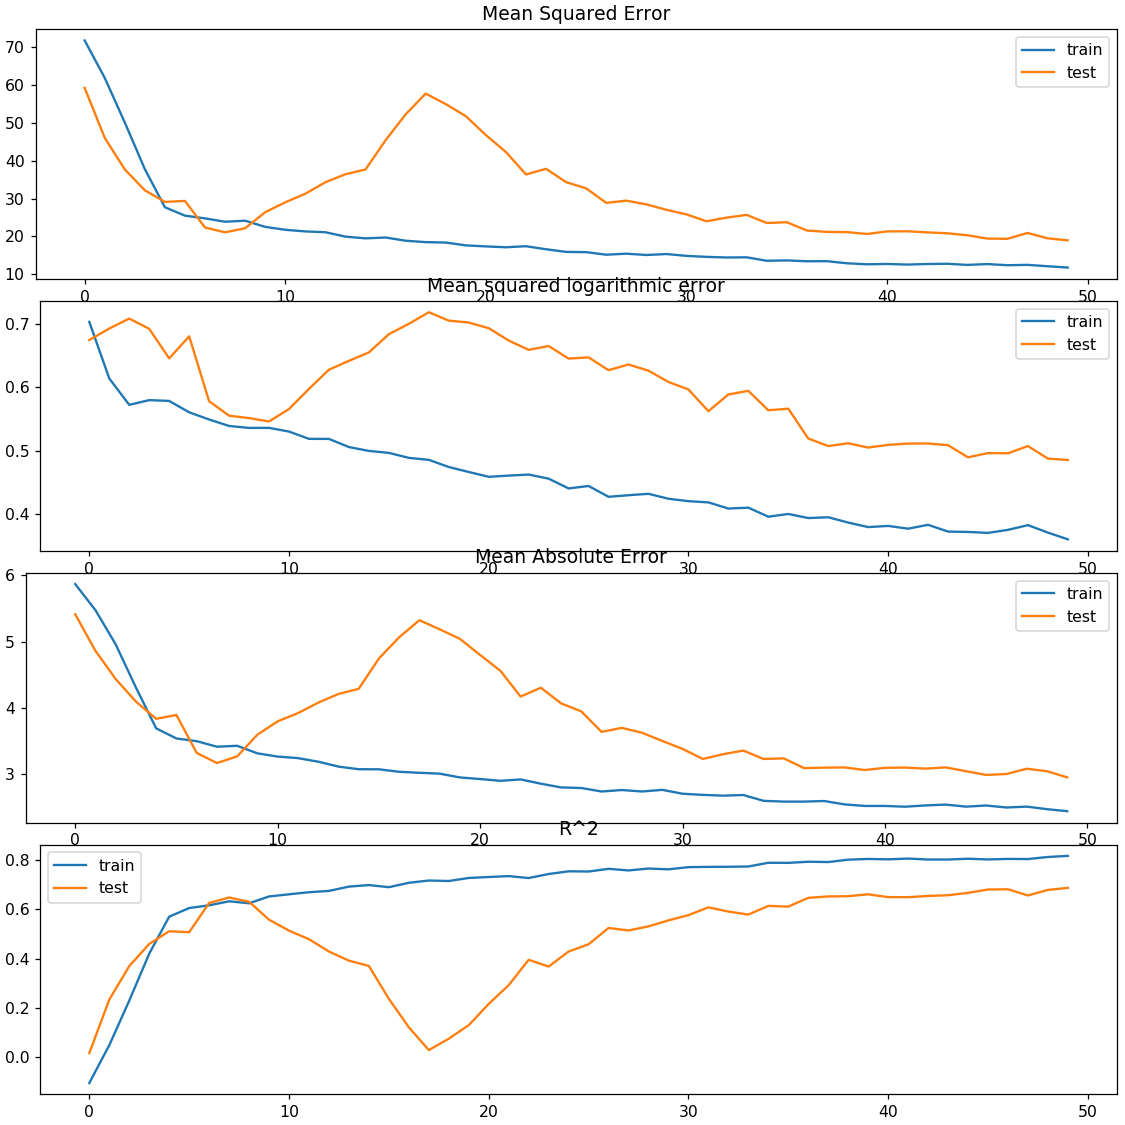

In [495]:
fig, ax = plt.subplots(4, 1, figsize=(10, 10), constrained_layout=True)
plt.subplot(411)
plt.title('Mean Squared Error')
plt.plot((train_dropout.history['loss']), label='train')
plt.plot((train_dropout.history['val_loss']), label='test')
plt.legend()
# plot mse during training
plt.subplot(412)
plt.title('Mean squared logarithmic error ')
plt.plot(train_dropout.history['mean_squared_logarithmic_error'], label='train')
plt.plot(train_dropout.history['val_mean_squared_logarithmic_error'], label='test')
plt.legend()
plt.subplot(413)
plt.title('Mean Absolute Error')
plt.plot((train_dropout.history['mean_absolute_error']), label='train')
plt.plot((train_dropout.history['val_mean_absolute_error']), label='test')
plt.legend()
plt.show()
plt.subplot(414)
plt.title('R^2')
plt.plot((train_dropout.history['coeff_determination']), label='train')
plt.plot((train_dropout.history['val_coeff_determination']), label='test')
plt.legend()
plt.show()

На первый взгляд кажется, что модель обучилась вполне успешно, но не стоит забывать, что при обучении учитывались и дозаполнения, которые ничего общего с реальностью не имеют

Проверим, насколько хорошо в действительности предсказались опорные матрицы

In [496]:
pred = model.predict(test_X)

In [497]:
from sklearn.metrics import r2_score
mme = 0
len_of_prot = []
fake_mean = []
fake_r2 = []
real_r2 = []
real_mean = []
#TT_pred = []
real_pred = []
real_test = []
for i in range(len(pred)):
        real_test_lab = []
        real_pred_lab = []
        r = np.sum(test_label[i].reshape(len(test_label[i])//5, 5), axis = 1)
        for j in range(len(r)-1):
            if r[j] == r[j + 1]:
                g=r[j]
                real_test_lab = test_label[i].reshape(len(test_label[i])//5, 5)[:int(r.tolist().index(g))]
                real_test.append(test_label[i][:int(r.tolist().index(g))*5])
                real_pred_lab = pred[i].reshape(len(test_label[i])//5, 5)[:int(r.tolist().index(g))]
                real_pred.append(pred[i][:int(r.tolist().index(g))*5])
                break
            if j == len(r)-2 and r[j] != r[j+1] :
                real_test_lab = test_label[i].reshape(len(test_label[i])//5, 5)
                real_pred_lab = pred[i].reshape(len(test_label[i])//5, 5)
                real_pred.append(pred[i])
                real_test.append(test_label[i])      
        len_of_prot.append(len(real_test_lab))
        fake_r2.append(r2_score(test_label[i], pred[i]))
        real_r2.append(r2_score(real_test_lab, real_pred_lab))
        real_mean.append(np.mean(abs(real_test_lab - real_pred_lab)))
        fake_mean.append(np.mean(abs(pred[i]-test_label[i])))

<IPython.core.display.Javascript object>


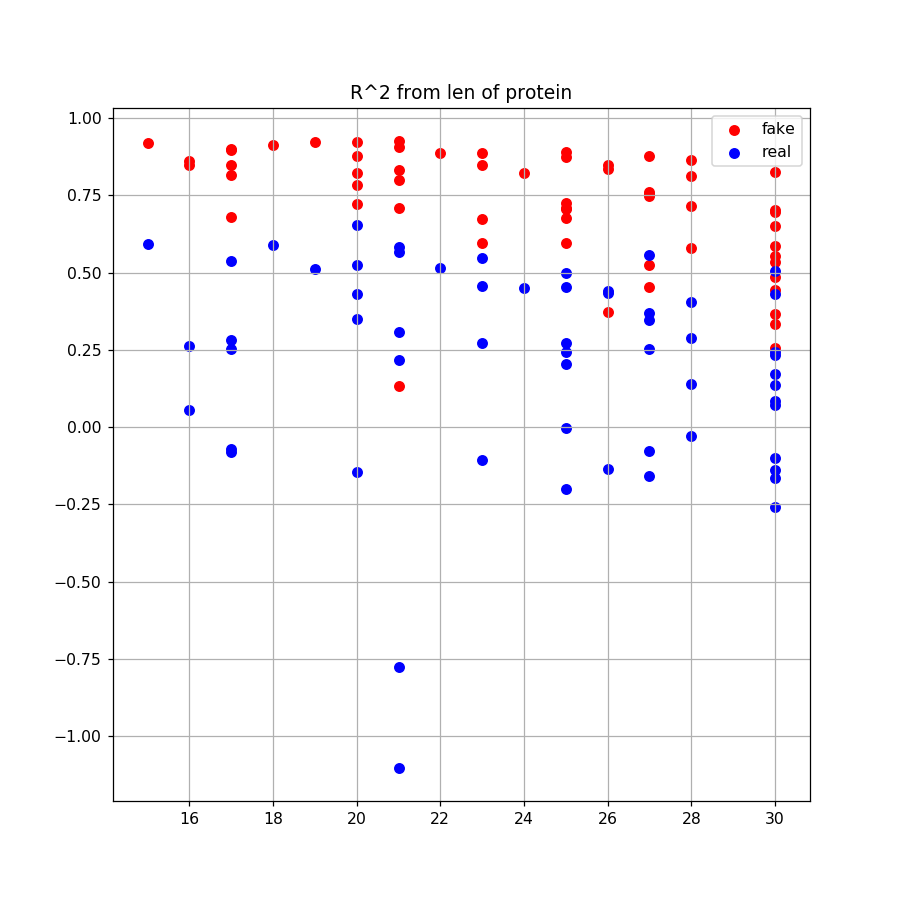

Fake 0.7207118731793428
Real 0.20665924977393121


In [498]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)
ax1.set_title('R^2 from len of protein')
ax1.scatter(len_of_prot, fake_r2, c = 'r', label = 'fake')
ax1.scatter(len_of_prot, real_r2, c = 'b', label = 'real')
ax1.legend()
ax1.grid()
print('Fake', np.mean(fake_r2))
print('Real', np.mean( real_r2))

<IPython.core.display.Javascript object>


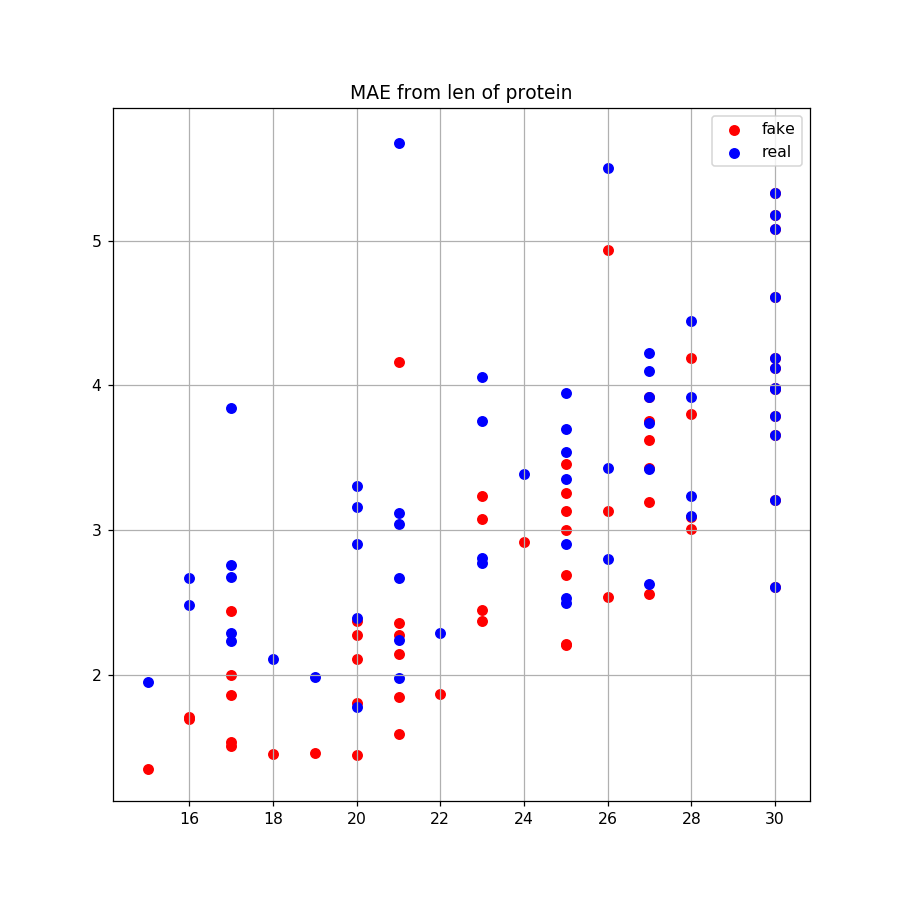

Fake 2.91862703468099
Real 3.339055024452317


In [499]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)
ax1.set_title('MAE from len of protein')
ax1.scatter(len_of_prot, fake_mean, c = 'r', label ='fake')
ax1.scatter(len_of_prot, real_mean, c = 'b', label = 'real')
ax1.legend()
ax1.grid()
print('Fake', np.mean(fake_mean))
print('Real', np.mean(real_mean))

<IPython.core.display.Javascript object>


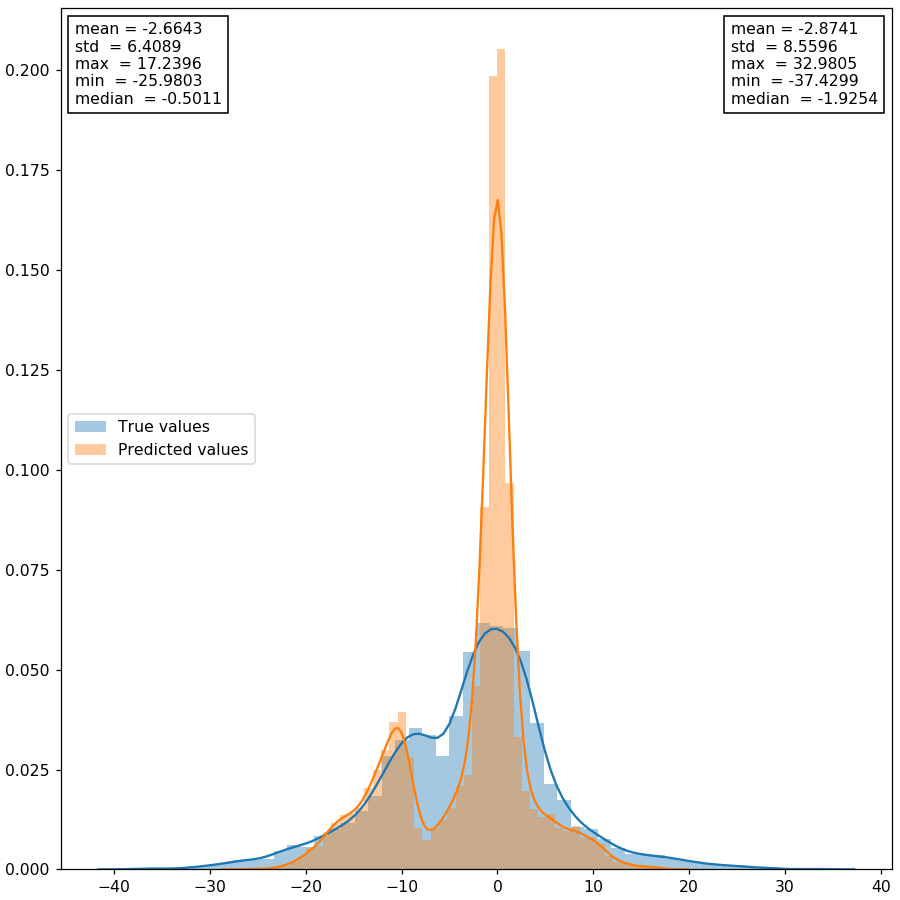

D:\Programms\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [500]:
lab_gr = np.array([x for sublist in real_test for x in sublist])
lab_gr1 = np.array([x for sublist in real_pred for x in sublist])
fig, ax = plt.subplots(1, 1, figsize=(8, 8), constrained_layout=True)
anchored_text = AnchoredText("mean = %.4f\n"
                                 "std  = %.4f\n"
                                 "max  = %.4f\n"
                                 "min  = %.4f\n"
                                 "median  = %.4f"
                                 % (lab_gr.mean(), lab_gr.std(), lab_gr.max(), 
                                    lab_gr.min(), np.median(lab_gr)), loc='upper right')
anchored_text1 = AnchoredText("mean = %.4f\n"
                                 "std  = %.4f\n"
                                 "max  = %.4f\n"
                                 "min  = %.4f\n"
                                 "median  = %.4f"
                                 % (lab_gr1.mean(), lab_gr1.std(), lab_gr1.max(), 
                                    lab_gr1.min(), np.median(lab_gr1)), loc='upper left')
ax.add_artist(anchored_text)
ax.add_artist(anchored_text1)
ax = sns.distplot(lab_gr, label = 'True values')
ax = sns.distplot(lab_gr1, label = 'Predicted values')
ax.legend( loc = 'center left')